## Bring in libraries and dataframes and set indexes

In [4]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import timedelta
import ETFunctions as et

Lattitude = -43.38
LongitudeTZ = 185
LongitudeML = 360 - 172.28

Path = 'K:\CPDiary\Data\BaxtersMVI'

## Set period to graph data over

In [5]:
Start = datetime.datetime(2017,10,18)
End = datetime.datetime(2018,1,8)

## Bring in data from Low zone and join to existing data

In [6]:
#Get the data that has already been indexed
ExistingLWCZoneData = pd.read_pickle(Path + '\LoggedData\DataFrames\LowWHCZoneAll.pkl')
LowWHCZoneAll = ExistingLWCZoneData.ix[Start:End,:]
#Set up other data frames
LowMetData = LowWHCZoneAll.ix[:,['AirTemp','RelativeHumidity','Wind']].copy()
LowMetData.columns = LowMetData.columns.droplevel([1,2,3])
LowMetData.index = LowMetData.index.to_datetime()
LowWHCZoneTs = LowWHCZoneAll.ix[:,'IR_SurfaceTemp'].copy()
LowWHCZoneTb = LowWHCZoneAll.ix[:,'IR_SensorBodyTemp'].copy()
LowWHCZoneBattery = LowWHCZoneAll.ix[:,'BatteryVoltage']

## Bring in data from Mid zone and join to existing data

In [7]:
#Get the data that has already been indexed
ExistingMWCZoneData = pd.read_pickle(Path + '\LoggedData\DataFrames\MidWHCZoneAll.pkl')
MidWHCZoneAll = ExistingMWCZoneData.ix[Start:End,:]
#Set up other data frames
MidMetData = MidWHCZoneAll.ix[:,['AirTemp','RelativeHumidity','RadnMJ','RadnkW','Rain','Wind']].copy()
MidMetData.index = MidMetData.index.to_datetime()
#Repair radiation data where incorrect coefficients were used
MidMetData.ix[:'2017-10-25 07:20:00','RadnkW'] = MidMetData.ix[:'2017-10-25 07:20:00','RadnkW'].divide(1000).values
MidMetData.ix[:'2017-10-25 07:20:00','RadnMJ'] = MidMetData.ix[:'2017-10-25 07:20:00','RadnkW'].multiply(0.3).values
MidWHCZoneTs = MidWHCZoneAll.ix[:,'IR_SurfaceTemp'].copy()
MidWHCZoneTb = MidWHCZoneAll.ix[:,'IR_SensorBodyTemp'].copy()
MidWHCZoneBattery = MidWHCZoneAll.ix[:,'BatteryVoltage']

## Bring in fresh data from High zone and join to existing data

In [8]:
#Get the data that has already been indexed
ExistingHWCZoneData = pd.read_pickle(Path + '\LoggedData\DataFrames\HighWHCZoneAll.pkl')
HighWHCZoneAll = ExistingHWCZoneData.ix[Start:End,:]
#Set up other data frames
HighMetData = HighWHCZoneAll.ix[:,['AirTemp','RelativeHumidity','Wind']].copy()
HighMetData.columns = HighMetData.columns.droplevel([1,2,3])
HighMetData.index = HighMetData.index.to_datetime()
HighWHCZoneTs = HighWHCZoneAll.ix[:,'IR_SurfaceTemp'].copy()
HighWHCZoneTb = HighWHCZoneAll.ix[:,'IR_SensorBodyTemp'].copy()
HighWHCZoneBattery = HighWHCZoneAll.ix[:,'BatteryVoltage']

## Join stuff together 

In [9]:
#Join everything together and get the formats all right
Zones = ['Low','Mid','High']
Irrigs = ['STD','VRI']
Reps = [1,2,3,4]
colors = ['r','r','g','g','b','b']
lines = ['--','-','--','-','--','-']
ExptIndex = pd.MultiIndex.from_product([Zones, Irrigs, Reps], names = ['Zone', 'Irrig', 'Rep'])
SurfaceTemp = pd.DataFrame(index = LowWHCZoneTs.index, columns = ExptIndex)
SurfaceTemp.update(LowWHCZoneTs)
SurfaceTemp.update(MidWHCZoneTs)
SurfaceTemp.update(HighWHCZoneTs)
SurfaceTemp.index = SurfaceTemp.index.to_datetime()
SurfaceTemp.dropna(inplace=True)
for plot in SurfaceTemp.columns:
    SurfaceTemp.ix[:,plot] = pd.to_numeric(SurfaceTemp.ix[:,plot])
HourlySurfaceTemp = SurfaceTemp.resample('H').mean()
SurfaceTempMeans = HourlySurfaceTemp.groupby(level=['Zone','Irrig'],axis=1).mean()

SensorTemp = pd.DataFrame(index = LowWHCZoneTb.index, columns = ExptIndex)
SensorTemp.update(LowWHCZoneTb)
SensorTemp.update(MidWHCZoneTb)
SensorTemp.update(HighWHCZoneTb)
SensorTemp.index = SensorTemp.index.to_datetime()
SensorTemp.dropna(inplace=True)

## Make data frame with aerodynamic Met variables

In [10]:
#Join the data from the three logger on each zone
DateTimeList = list(set().union(HighMetData.index,MidMetData.index,LowMetData.index))
list.sort(DateTimeList)
MetIndex = pd.MultiIndex.from_product([Zones,DateTimeList],names=['Zone','Date'])
MetData = pd.DataFrame(index = MetIndex, columns = ['Ta','RH','u','Es','Eo','Ed','Rs','Rex','Rso'])
MetFiles = [LowMetData,MidMetData,HighMetData]
zoneIndex = 0
for zone in Zones:
    zoneMet = MetFiles[zoneIndex]
    MetData.ix[[zone],'Ta'] = zoneMet.ix[DateTimeList,'AirTemp'].values
    MetData.ix[[zone],'RH'] = zoneMet.ix[DateTimeList,'RelativeHumidity'].values/100
    MetData.ix[[zone],'u'] = zoneMet.ix[DateTimeList,'Wind'].values
    MetData.ix[[zone],'Rs'] = MidMetData.ix[DateTimeList,'RadnMJ'].values
    zoneIndex += 1
#Plug T and RH data for Low and High treatments with data from Mid treatment
FullInstrumentationDate = '2017-10-30 13:05:00'
MissingDataDates = MetData.ix['Low',:].ix[:FullInstrumentationDate].index
for mdd in MissingDataDates:
    MetData.ix[('Low',mdd),'Ta'] = MetData.ix[('Mid',mdd),'Ta']
    MetData.ix[('High',mdd),'Ta'] = MetData.ix[('Mid',mdd),'Ta']
    MetData.ix[('Low',mdd),'RH'] = MetData.ix[('Mid',mdd),'RH']
    MetData.ix[('High',mdd),'RH'] = MetData.ix[('Mid',mdd),'RH']
#Derive values from measured met data
MetData.ix[:,'Es'] = [et.saturated_vapor_pressure(MetData.ix[d,'Ta'])/10 for d in MetData.index]
MetData.ix[:,'Eo'] = [MetData.ix[d,'Es'] * MetData.ix[d,'RH'] for d in MetData.index]
MetData.ix[:,'Ed'] = MetData.ix[:,'Es'] - MetData.ix[:,'Eo']
MetData.ix[:,'Rex'] = [et.ExtraterestialRadiation(Lattitude,
                                                       d[1].dayofyear,
                                                       0.083333,
                                                       float(d[1].time().hour) + float(d[1].time().minute)/60.0,
                                                       LongitudeTZ,
                                                       LongitudeML) for d in MetData.index]
MetData.ix[:,'Rso'] = [et.ClearSkyRadiation(Lattitude,
                                                 d[1].dayofyear,
                                                 0.083333,
                                                 float(d[1].time().hour) + float(d[1].time().minute)/60.0,
                                                 LongitudeTZ,
                                                 LongitudeML) for d in MetData.index]

MetData.sort_index(inplace=True)

## Check some status stuff

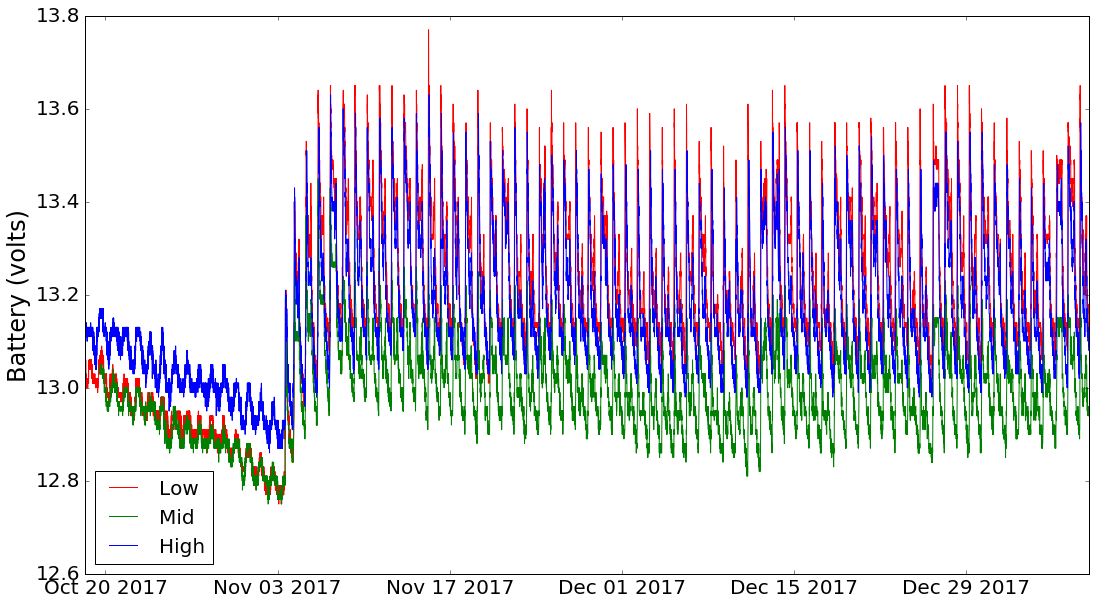

In [11]:
BatteryVoltage = plt.figure(figsize=(18,10))
plt.plot(LowWHCZoneBattery,c='r',label='Low')
plt.plot(MidWHCZoneBattery,c='g',label='Mid')
plt.plot(HighWHCZoneBattery,c='b',label='High')
plt.legend(loc=3,fontsize=20)
plt.tick_params(labelsize=20)
plt.ylabel('Battery (volts)',fontsize = 24)

C:\Users\cflhxb\AppData\Roaming\Python\Python27\site-packages\ipykernel\ipkernel.py:199: PerformanceWarning: indexing past lexsort depth may impact performance.
  shell.run_cell(code, store_history=store_history, silent=silent)
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:76: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


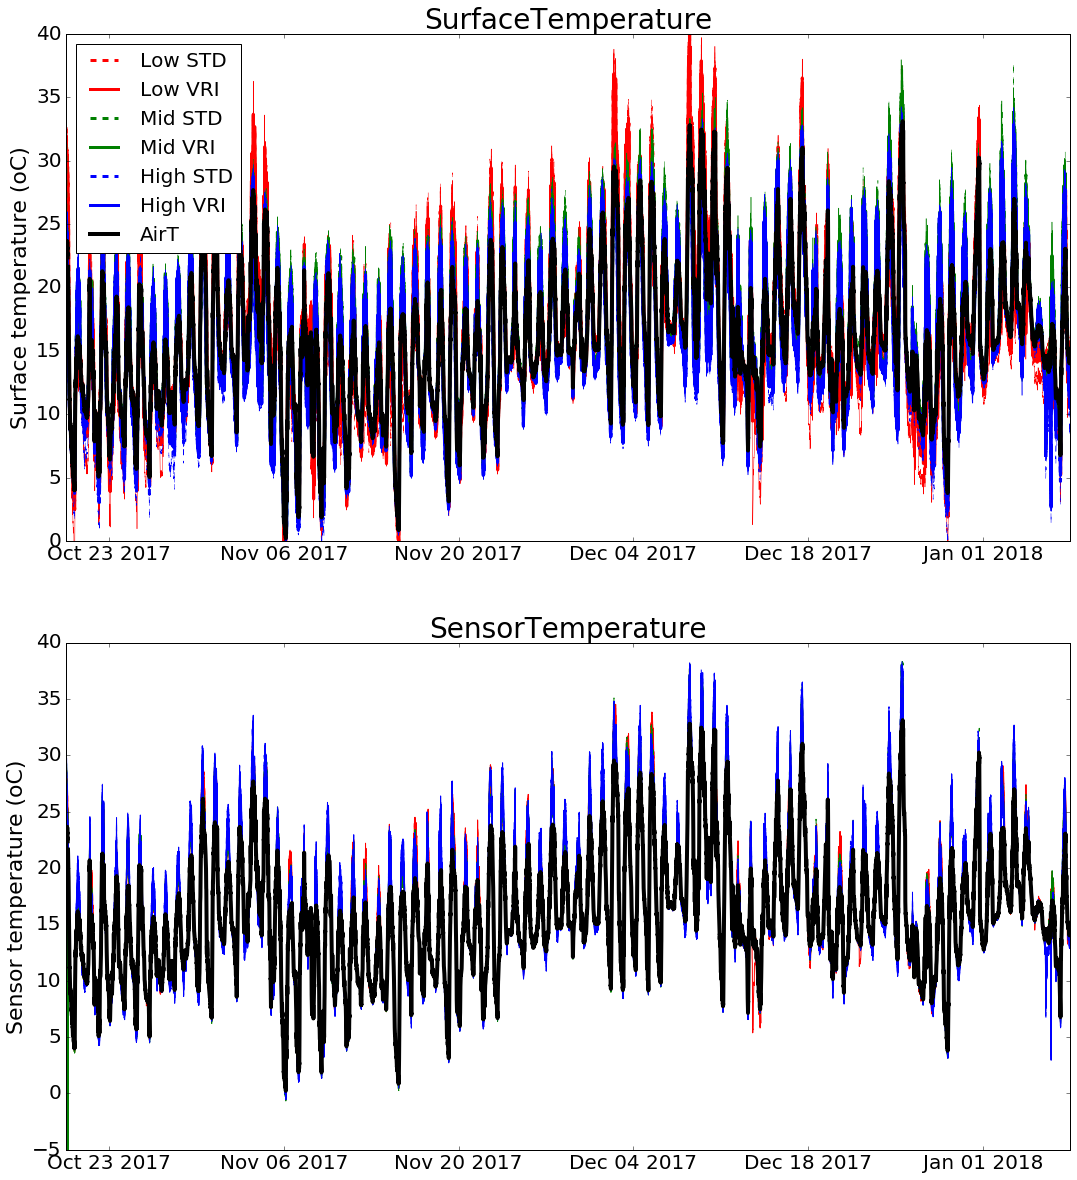

In [12]:
Graph = plt.figure(figsize=(18,20))
pos = 0
Fig = Graph.add_subplot(2,1,1)
for Zone in Zones:
    for Irr in Irrigs:
        lab = Zone + ' ' + Irr
        data = SurfaceTemp.ix[Start:End,(Zone,Irr)]
        plt.plot(data,lines[pos],color = colors[pos],lw=0.5,label = '_nolegend_')
        plt.plot(data.index,data.mean(axis=1),lines[pos],color = colors[pos],lw=3,label = lab)
        pos +=1
plt.plot(MidMetData.ix[Start:End,'AirTemp'],color='k',lw=4,label='AirT')
Fig.legend(loc=2,fontsize=20)
plt.title('SurfaceTemperature',fontsize=28)
plt.tick_params(labelsize=20)
plt.ylabel('Surface temperature (oC)',fontsize = 22)
plt.ylim(0,40)
Graph.add_subplot(2,1,2)
pos = 0
for Zone in Zones:
    for Irr in Irrigs:
        data = SensorTemp.ix[Start:End,(Zone,Irr)]
        plt.plot(data,lines[pos],color = colors[pos])
        pos +=1
plt.plot(MidMetData.ix[Start:End,'AirTemp'],color='k',lw=4)
plt.ylim(-5,40)
plt.tick_params(labelsize=20)
plt.title('SensorTemperature',fontsize=28)
plt.ylabel('Sensor temperature (oC)',fontsize = 22)

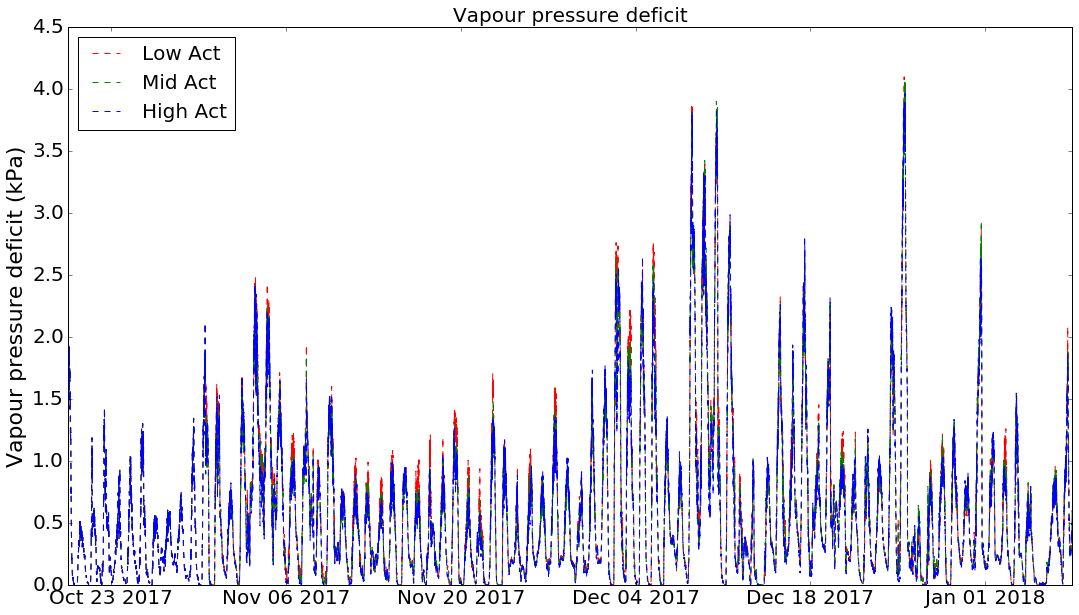

In [13]:
VPGraph = plt.figure(figsize=(18,10))
colpos = 0
for zone in Zones:
    plt.plot(MetData.ix[zone,'Ed'].ix[Start:End],'--',color = colors[colpos], label = zone + ' Act')
    colpos+=2
plt.legend(loc=2,fontsize=20)
plt.title('Vapour pressure deficit',fontsize=20)
plt.ylabel('Vapour pressure deficit (kPa)',fontsize=22)
plt.tick_params(labelsize=20)

(0, 10)

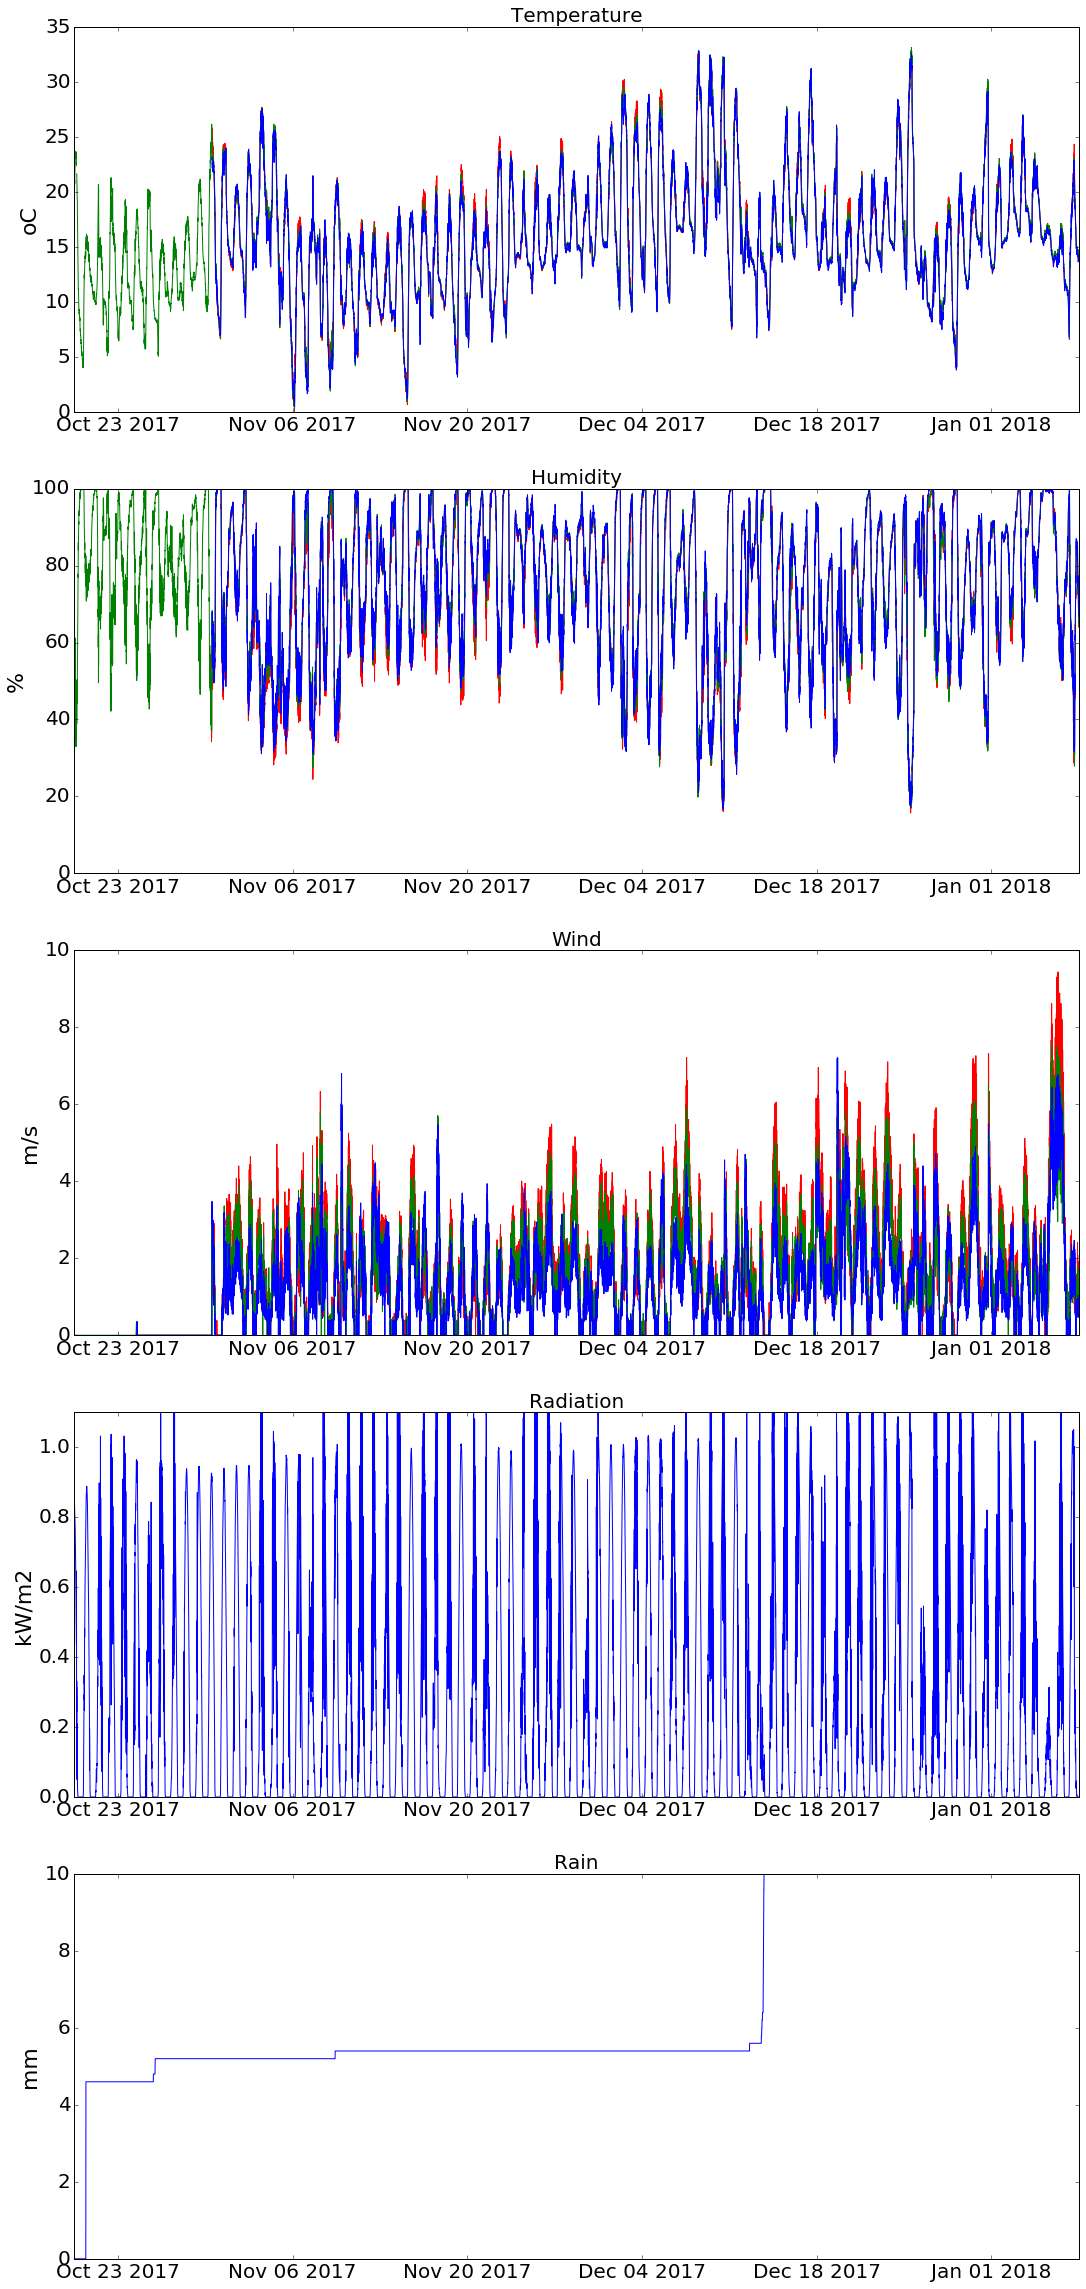

In [14]:
MetGraph = plt.figure(figsize=(18,40))
TempPannel = MetGraph.add_subplot(5,1,1)
plt.plot(LowMetData.ix[Start:End,'AirTemp'],color = 'r')
plt.plot(MidMetData.ix[Start:End,'AirTemp'],color = 'g')
plt.plot(HighMetData.ix[Start:End,'AirTemp'],color = 'b')
plt.title('Temperature',fontsize=20)
plt.ylabel('oC',fontsize=22)
plt.tick_params(labelsize=20)
plt.ylim(0,35)
HumidityPannel = MetGraph.add_subplot(5,1,2)
plt.plot(LowMetData.ix[Start:End,'RelativeHumidity'],color = 'r')
plt.plot(MidMetData.ix[Start:End,'RelativeHumidity'],color = 'g')
plt.plot(HighMetData.ix[Start:End,'RelativeHumidity'],color = 'b')
plt.title('Humidity',fontsize=20)
plt.ylabel('%',fontsize=22)
plt.tick_params(labelsize=20)
plt.ylim(0,100)
WindPannel = MetGraph.add_subplot(5,1,3)
plt.plot(LowMetData.ix[Start:End,'Wind'],color = 'r')
plt.plot(MidMetData.ix[Start:End,'Wind'],color = 'g')
plt.plot(HighMetData.ix[Start:End,'Wind'],color = 'b')
plt.title('Wind',fontsize=20)
plt.ylabel('m/s',fontsize=22)
plt.tick_params(labelsize=20)
plt.ylim(0,10)
RadnPannel = MetGraph.add_subplot(5,1,4)
plt.plot(MidMetData.ix[Start:End,'RadnkW'])
plt.title('Radiation',fontsize=20)
plt.ylabel('kW/m2',fontsize=22)
plt.tick_params(labelsize=20)
plt.ylim(0,1.100)
RainfallPannel = MetGraph.add_subplot(5,1,5)
plt.plot(MidMetData.ix[Start:End,'Rain'].cumsum())
plt.title('Rain',fontsize=20)
plt.ylabel('mm',fontsize=22)
plt.tick_params(labelsize=20)
plt.ylim(0,10)

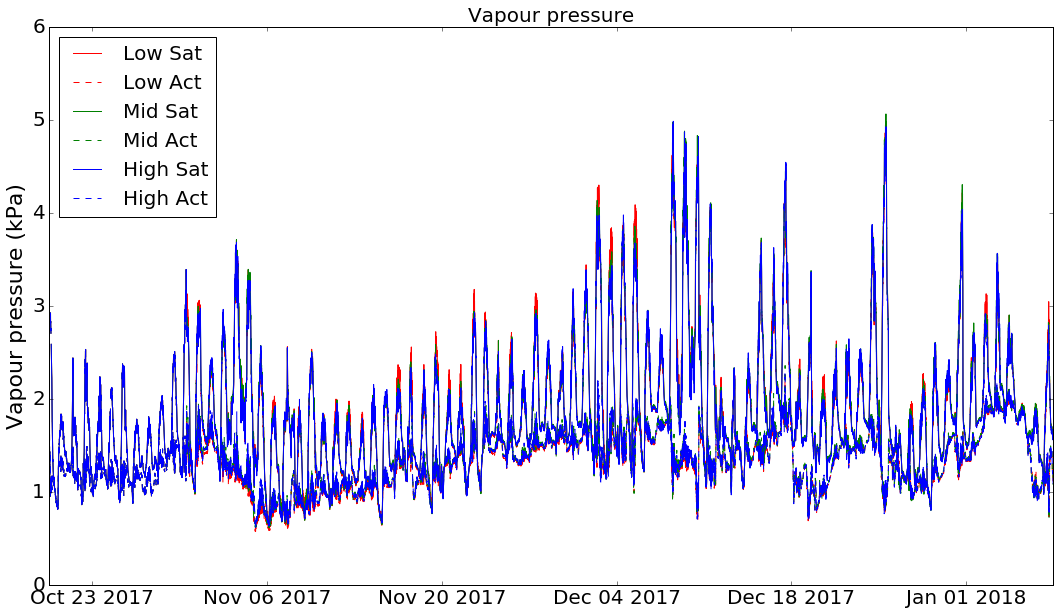

In [15]:
VPGraph = plt.figure(figsize=(18,10))
colpos = 0
for zone in Zones:
    plt.plot(MetData.ix[zone,'Es'].ix[Start:End],color = colors[colpos], label = zone + ' Sat')
    plt.plot(MetData.ix[zone,'Eo'].ix[Start:End],'--',color = colors[colpos], label = zone + ' Act')
    colpos+=2
plt.legend(loc=2,fontsize=20)
plt.title('Vapour pressure',fontsize=20)
plt.ylabel('Vapour pressure (kPa)',fontsize=22)
plt.tick_params(labelsize=20)

In [16]:
Daylight = (MetData.ix['Mid','Rs'] > 0.01) & (MetData.ix['Mid','Rs'].index > '2017-10-15') & (MetData.ix['Mid','Ed'] > 0.1)

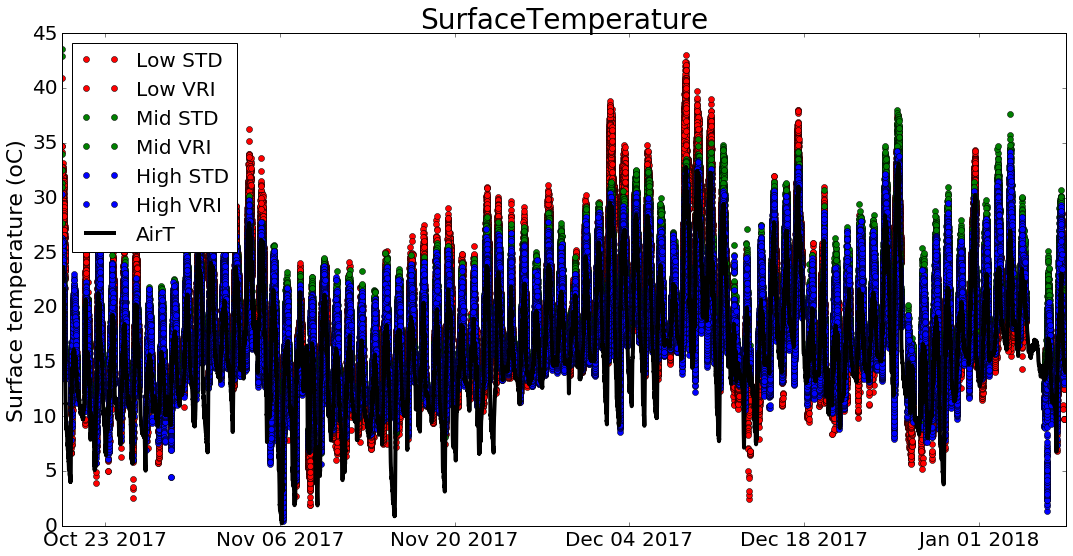

In [17]:
Graph = plt.figure(figsize=(18,30))
pos = 0
Fig = Graph.add_subplot(3,1,1)
for Zone in Zones:
    for Irr in Irrigs:
        lab = Zone + ' ' + Irr
        data = SurfaceTemp.ix[Daylight,(Zone,Irr)].ix[Start:End]
        plt.plot(data,'o',color = colors[pos],lw=0.5,label = '_nolegend_')
        plt.plot(data.index,data.mean(axis=1),'o',color = colors[pos],lw=3,label = lab)
        pos +=1
plt.plot(MidMetData.ix[Start:End,'AirTemp'],color='k',lw=4,label='AirT')
Fig.legend(loc=2,fontsize=20)
plt.title('SurfaceTemperature',fontsize=28)
plt.tick_params(labelsize=20)
plt.ylabel('Surface temperature (oC)',fontsize = 22)

## Bring in the albedo and cover data

(0, 1.1)

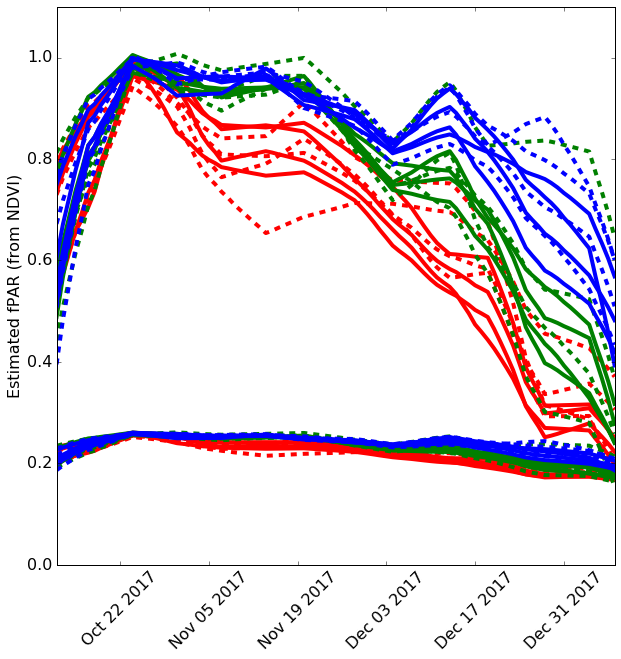

In [18]:
Albedo = pd.read_pickle('Albedo.pkl')
fPAR = pd.read_pickle('fPAR.pkl')

NDVIGraph = plt.figure(figsize=(10,10))
pos = 0
for Zone in Zones:
    for Irrig in Irrigs:
        plt.plot(Albedo.index,Albedo.ix[:,(Zone,Irrig)],lines[pos],color=colors[pos],label=Zone+Irrig,lw=4)
        plt.plot(fPAR.index,fPAR.ix[:,(Zone,Irrig)],lines[pos],color=colors[pos],label='_nolegend_',lw=4)
        pos+=1
plt.ylabel('Estimated fPAR (from NDVI)',fontsize=16)
plt.xticks(rotation=45)
plt.tick_params(labelsize=16)
plt.ylim(0,1.1)
#plt.legend(loc=2,fontsize=16)

## Calculate net radiation for each plot

In [19]:
#Bring in the calculations already made
ExistingRadnCalcs = pd.read_pickle(Path + '\LoggedData\DataFrames\NetRadData.pkl')
LastCalcTo = ExistingRadnCalcs.index.max()
EBDates = list(set([DateTimeList[x].date() for x in range(len(DateTimeList))]))
list.sort(EBDates)
RadnCols = pd.MultiIndex.from_product([Zones,Irrigs,Reps],names=['Zone','Irrig','Rep'])
NetRadData = pd.DataFrame(index = DateTimeList, columns = RadnCols)
NetRadData.update(ExistingRadnCalcs)
#Calcualate parameters for the fresh data
for plot in NetRadData.columns:
    NetRadData.ix[LastCalcTo:,plot] = [et.NetRadiation(MetData.ix[(plot[0],d),'Rs'],
                                                    MetData.ix[(plot[0],d),'Ta'],
                                                    MetData.ix[(plot[0],d),'Eo'],
                                                    Lattitude,
                                                    d.dayofyear,
                                                    0.083333,
                                                    float(d.time().hour) + float(d.time().minute)/60.0,
                                                    LongitudeTZ,
                                                    LongitudeML,
                                                    Albedo.ix[EBDates,:].ix[d.date(),plot]) for d in NetRadData.ix[LastCalcTo:,:].index]
NetRadData.to_pickle(Path + '\LoggedData\DataFrames\NetRadData.pkl')

## Have a look at sub daily radiation

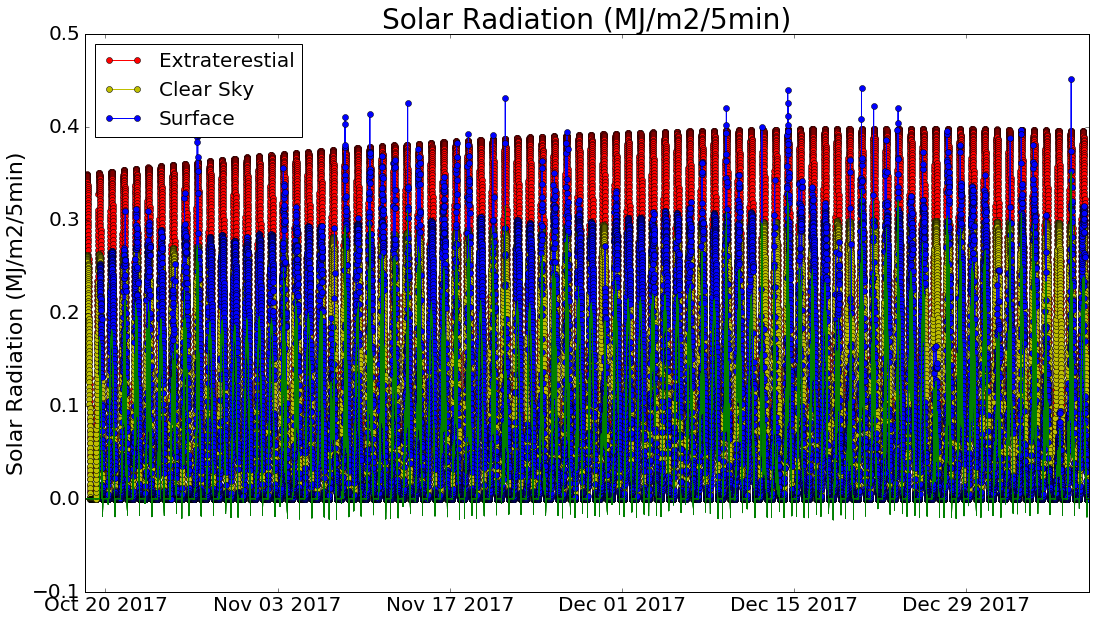

In [20]:
figure = plt.figure(figsize=(18,10))
plt.plot(MetData.ix['Mid','Rex'].ix[Start:End],'-o',color='r',label='Extraterestial')
plt.plot(MetData.ix['Mid','Rso'].ix[Start:End],'-o',color='y',label='Clear Sky')
plt.plot(MetData.ix['Mid','Rs'].ix[Start:End],'-o',color='b',label='Surface')
for plot in NetRadData.columns:
    plt.plot(NetRadData.ix[Start:End,plot],color = 'g',lw=0.5,label = '_nolegend_')
plt.legend(loc=2,fontsize=20)
plt.title('Solar Radiation (MJ/m2/5min)',fontsize=28)
plt.tick_params(labelsize=20)
plt.ylabel('Solar Radiation (MJ/m2/5min)',fontsize = 22)

## Calculate daily values for input data

In [41]:
def estGDay(SoilRadn, AirTemp):
    Const = -0.7091
    SoilRadEff = np.multiply(SoilRadn.values,0.2149)
    AirTempEff = np.multiply(AirTemp.values,0.0736)
    return Const + SoilRadEff  + AirTempEff 

#Calculate Ts for each plot
Ts = SurfaceTemp.ix[Daylight,:].dropna().resample('d').mean()
#Calculate Rn for each plot
Rn = NetRadData.resample('d').sum().ix[Ts.index]
#calculate Rs for the experiment
Rs = MetData.ix['Mid','Rs'].resample('d').sum().ix[Ts.index]
#Calculate Ta for each zone
Ta = pd.DataFrame(index = Rn.index, columns = Zones)
for zone in Ta.columns:
    Ta.ix[:,zone] = pd.to_numeric(MetData.ix[zone,'Ta'].ix[Daylight]).resample('d').mean()
#Calculate Ed for each zone
Ed = pd.DataFrame(index = Rn.index, columns = Zones)
for zone in Ta.columns:
    Ed.ix[:,zone] = pd.to_numeric(MetData.ix[zone,'Ed'].ix[Daylight]).resample('d').mean()
#Calculate G for each plot
G = pd.DataFrame(index=Rn.index, columns=Rn.columns)
for plot in G.columns:
    G.ix[:,plot] = estGDay(Rs * (1-fPAR.ix[G.index,plot]), Ta.ix[:,plot[0]])
RnLessG = Rn - G
#Calculate u for each zone
u = pd.DataFrame(index = Rn.index, columns = Zones)
for zone in u.columns:
    u.ix[:,zone] = pd.to_numeric(MetData.ix[zone,'u'].ix[Daylight]).resample('d').mean()

## Check daily radiation data

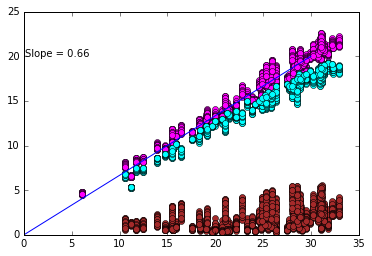

In [22]:
pos=0
for Zone in Zones:
    for Irr in Irrigs:
        lab = Zone + ' ' + Irr
        plt.plot(Rs,Rn.ix[:,(Zone,Irr)],'o',color = 'magenta',lw=0.5,label = 'Net Rad (Rn)')
        plt.plot(Rs,G.ix[:,(Zone,Irr)],'o',color = 'brown',lw=0.5,label = 'Ground Heat (G)')
        plt.plot(Rs,RnLessG.ix[:,(Zone,Irr)],'o',color = 'cyan',lw=0.5,label = 'Rn - G')
        pos +=1
plt.plot([0,30],[0,20],'-')
plt.text(0.1,20,'Slope = 0.66')
plt.plot([0,30],[0,0],'-')

## Calculate temperature variables from measured data

In [23]:
#Calculate aerodynamic temperature
To = pd.DataFrame(index = Rn.index,columns=Rn.columns)
for plot in To.columns:
    To.ix[:,plot] = Ts.ix[:,plot] + Ed.ix[:,plot[0]]
    
#Calculate temperature difference
Td = pd.DataFrame(index = Rn.index,columns=Rn.columns)
for plot in Td.columns:
    Td.ix[:,plot] = To.ix[:,plot] - Ta.ix[:,plot[0]]
#Calculate alpha
def AlphaCoeff(Td,fPAR):
    CoverFact = 0.1+1.6*fPAR
    if CoverFact > 1.0:
        CoverFact = 1.0
    return 1/(0.68 + 0.18*Td ) * CoverFact

Alpha = pd.DataFrame(index = Rn.index,columns=Rn.columns)
for plot in Alpha.columns:
    Alpha.ix[:,plot] = [AlphaCoeff(Td.ix[x,plot],
                                   fPAR.ix[x,plot]) for x in Alpha.index]

#Estimate Water Use by surfaces
E = pd.DataFrame(index = Rn.index,columns=Rn.columns)
for plot in E.columns:
    E.ix[:,plot] = [et.Priestly_TaylorEO(RnLessG.ix[x,plot],
                                         Ta.ix[x,plot[0]],
                                         Alpha.ix[x,plot],
                                         'net') for x in E.index]

In [49]:
DailyData = pd.DataFrame(Ts.unstack())
DailyData.columns = ['Ts']
DailyVariables = ['Rn','G','To','Td','Alpha','E','Albedo','fPAR']
for Var in DailyVariables:
    VarFrame = globals()[Var]
    Varunstk = pd.DataFrame(VarFrame.unstack())
    Varunstk.columns = [Var]
    DailyData = DailyData.join(Varunstk)

In [50]:
DailyData.ix[:,'Rs'] = np.nan
DailyData.ix[:,'Ed'] = np.nan
DailyData.ix[:,'Ta'] = np.nan
DailyData.ix[:,'u'] = np.nan
for Z in Zones:
    for I in Irrigs:
        for R in Reps:
            DailyData.ix[(Z,I,R),'Rs'] = Rs.values
            DailyData.ix[(Z,I,R),'Ed'] = Ed.ix[:,Z].values
            DailyData.ix[(Z,I,R),'Ta'] = Ta.ix[:,Z].values
            DailyData.ix[(Z,I,R),'u'] = u.ix[:,Z].values

In [52]:
DailyData.to_excel('K:\CPDiary\Data\BaxtersMVI\TempNRadRawData1.xlsx',merge_cells=False,sheet_name='RawData')

## Take a look at some of the daily data

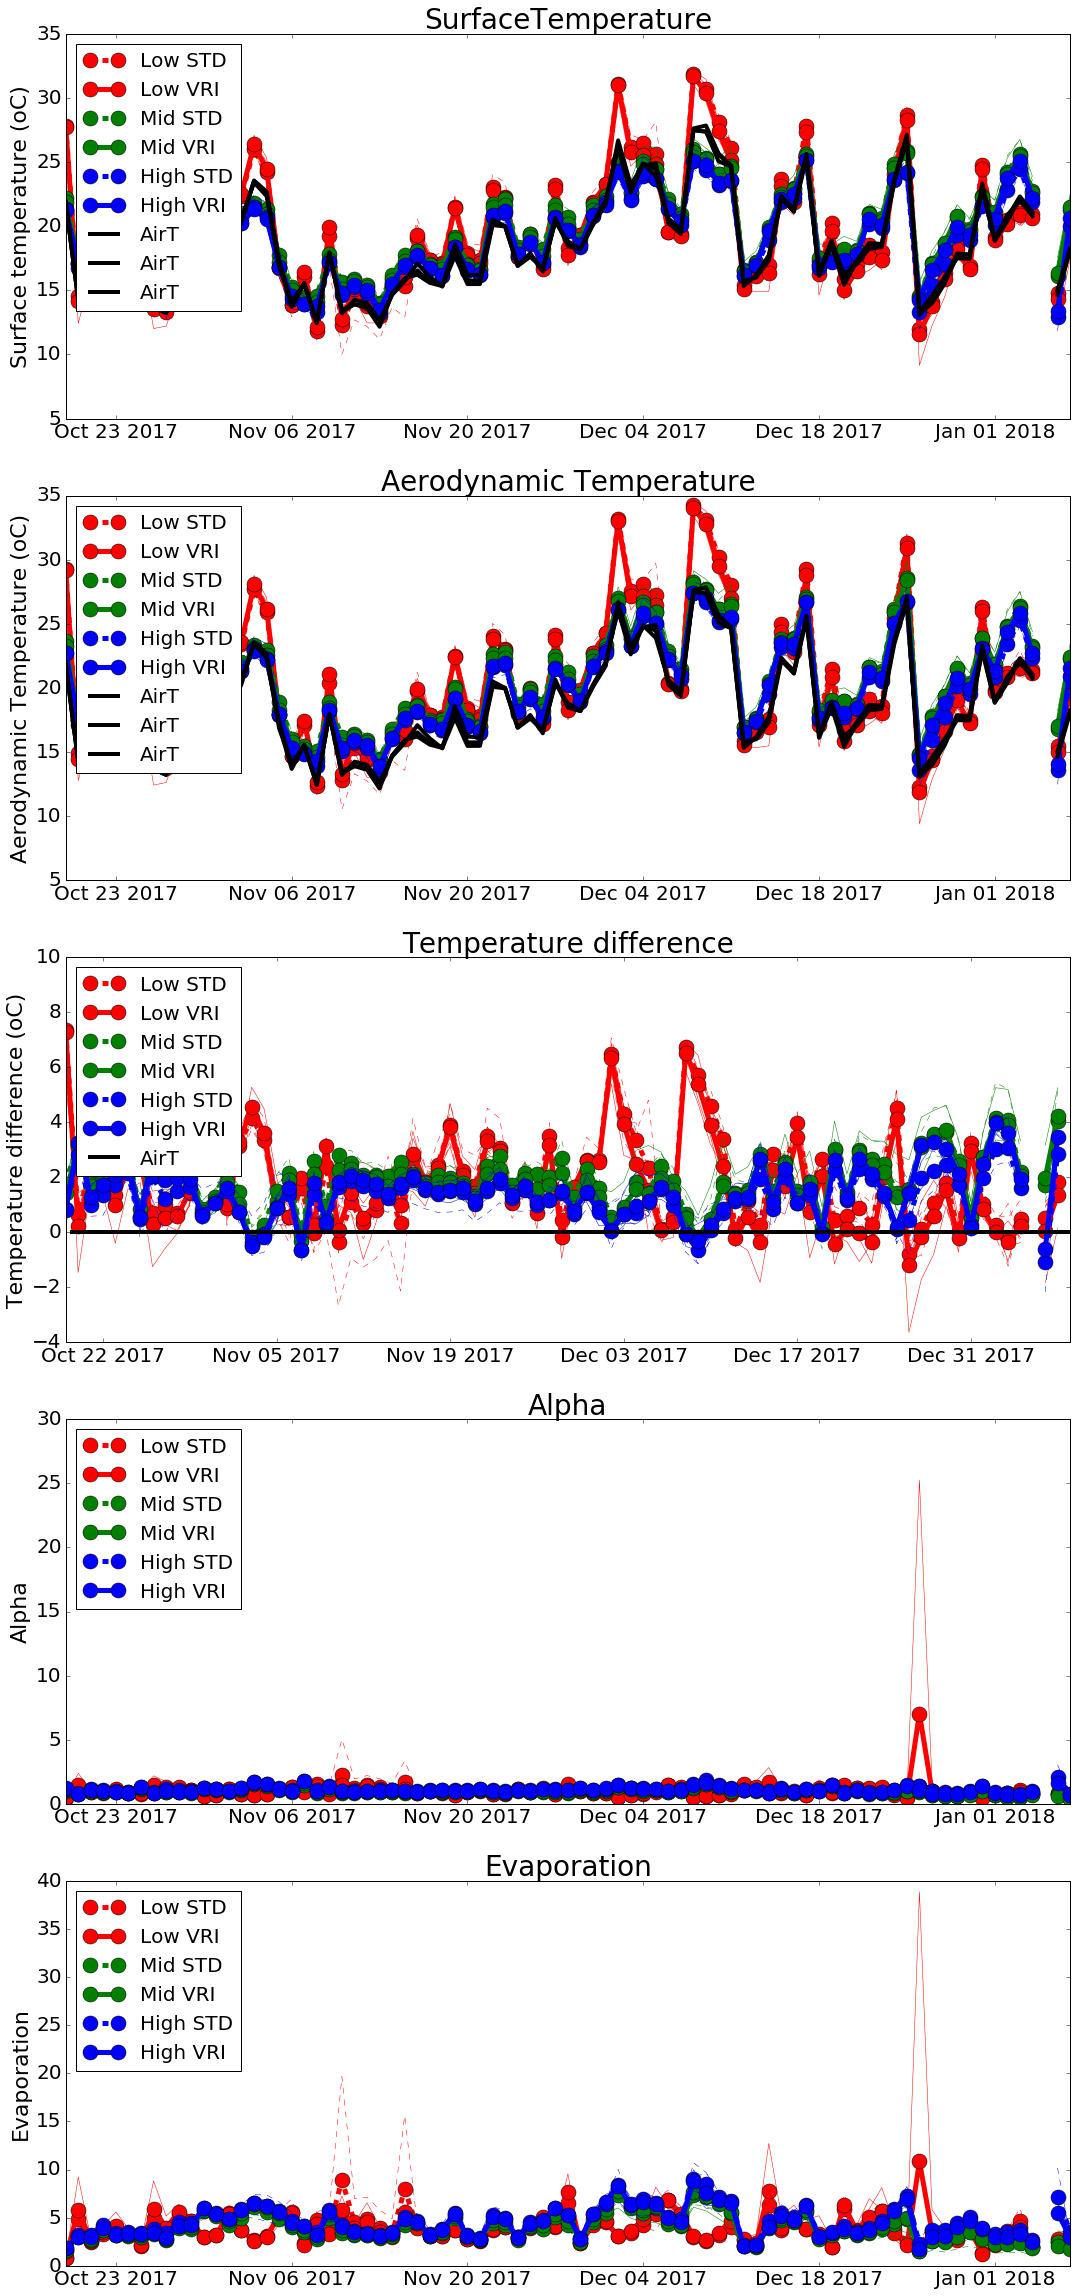

In [30]:
#Start = Today - timedelta(days=12)
Graph = plt.figure(figsize=(18,40))
pos = 0
Fig = Graph.add_subplot(5,1,1)
for Zone in Zones:
    for Irr in Irrigs:
        lab = Zone + ' ' + Irr
        data = Ts.ix[:,(Zone,Irr)].ix[Start:End]
        plt.plot(data,lines[pos],color = colors[pos],lw=0.5,label = '_nolegend_')
        plt.plot(data.index,data.mean(axis=1),lines[pos]+'o',color = colors[pos],lw=5,label = lab,ms=15)
        pos +=1
plt.plot(Ta.ix[Start:End],color='k',lw=4,label='AirT')
Fig.legend(loc = 2, fontsize=20)
plt.title('SurfaceTemperature',fontsize=28)
plt.tick_params(labelsize=20)
plt.ylabel('Surface temperature (oC)',fontsize = 22)
pos=0
Fig = Graph.add_subplot(5,1,2)
for Zone in Zones:
    for Irr in Irrigs:
        lab = Zone + ' ' + Irr
        data = To.ix[:,(Zone,Irr)].ix[Start:End]
        plt.plot(data,lines[pos],color = colors[pos],lw=0.5,label = '_nolegend_')
        plt.plot(data.index,data.mean(axis=1),lines[pos]+'o',color = colors[pos],lw=5,label = lab,ms=15)
        pos +=1
plt.plot(Ta.ix[Start:End],color='k',lw=4,label='AirT')
Fig.legend(loc = 2, fontsize=20)
plt.title('Aerodynamic Temperature',fontsize=28)
plt.tick_params(labelsize=20)
plt.ylabel('Aerodynamic Temperature (oC)',fontsize = 22)
pos=0
Fig = Graph.add_subplot(5,1,3)
for Zone in Zones:
    for Irr in Irrigs:
        lab = Zone + ' ' + Irr
        data = Td.ix[:,(Zone,Irr)].ix[Start:End]
        plt.plot(data,lines[pos],color = colors[pos],lw=0.5,label = '_nolegend_')
        plt.plot(data.index,data.mean(axis=1),lines[pos]+'o',color = colors[pos],lw=5,label = lab,ms=15)
        pos +=1
plt.plot([MidMetData.ix[Start:End,'AirTemp'].index.min(),MidMetData.index.max().date()],[0,0],color='k',lw=4,label='AirT')
Fig.legend(loc = 2, fontsize=20)
plt.title('Temperature difference',fontsize=28)
plt.tick_params(labelsize=20)
plt.ylabel('Temperature difference (oC)',fontsize = 22)
pos=0
Fig = Graph.add_subplot(5,1,4)
for Zone in Zones:
    for Irr in Irrigs:
        lab = Zone + ' ' + Irr
        data = Alpha.ix[:,(Zone,Irr)].ix[Start:End]
        plt.plot(data,lines[pos],color = colors[pos],lw=0.5,label = '_nolegend_')
        plt.plot(data.index,data.mean(axis=1),lines[pos]+'o',color = colors[pos],lw=5,label = lab,ms=15)
        pos +=1
Fig.legend(loc = 2, fontsize=20)
plt.title('Alpha',fontsize=28)
plt.tick_params(labelsize=20)
plt.ylabel('Alpha',fontsize = 22)
pos=0
Fig = Graph.add_subplot(5,1,5)
for Zone in Zones:
    for Irr in Irrigs:
        lab = Zone + ' ' + Irr
        data = E.ix[:,(Zone,Irr)].ix[Start:End]
        plt.plot(data,lines[pos],color = colors[pos],lw=0.5,label = '_nolegend_')
        plt.plot(data.index,data.mean(axis=1),lines[pos]+'o',color = colors[pos],lw=5,label = lab,ms=15)
        pos +=1
Fig.legend(loc = 2, fontsize=20)
plt.title('Evaporation',fontsize=28)
plt.tick_params(labelsize=20)
plt.ylabel('Evaporation',fontsize = 22)

##  Remove data from plots where sensors are planying up

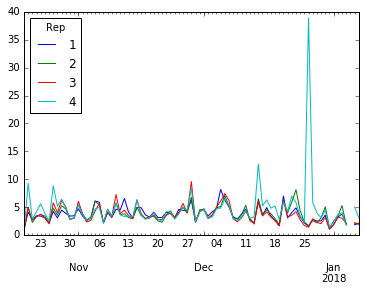

In [31]:
E.ix[:,('Low','VRI')].plot()

In [32]:
#E.ix[:,('High','STD',1.0)] = np.nan
E.ix[:,('Low','VRI',4.0)] = np.nan

## Work out how much irrigation is needed
### Enter the date of last irrigation (in yyyy-mm-dd format).  
### The graph is accumulated water use less rainfall from (including) that date up to yesterday

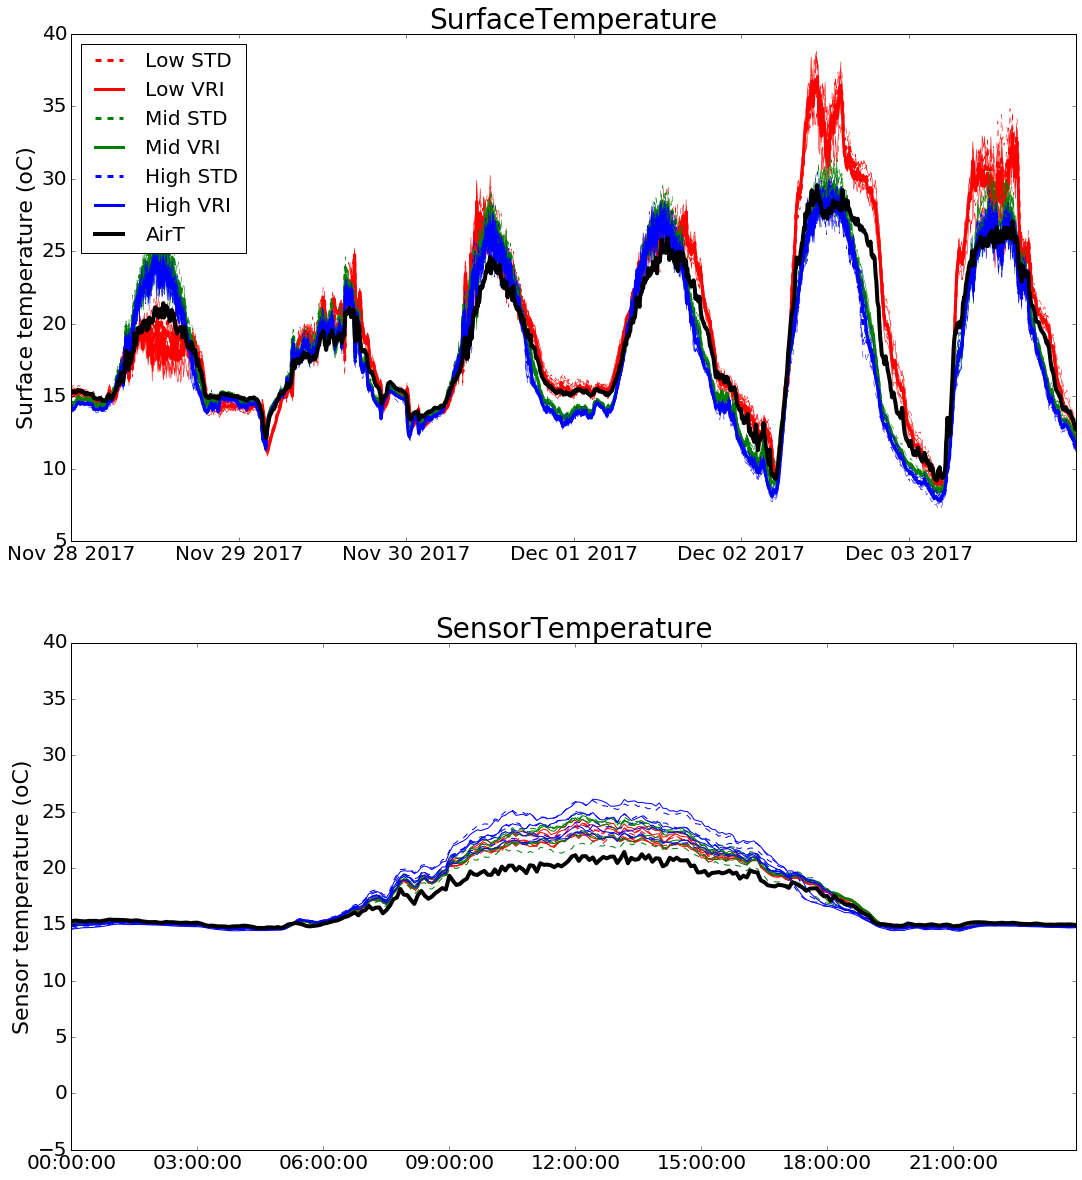

In [33]:
Graph = plt.figure(figsize=(18,20))
pos = 0
Fig = Graph.add_subplot(2,1,1)
for Zone in Zones:
    for Irr in Irrigs:
        lab = Zone + ' ' + Irr
        data = SurfaceTemp.ix['2017-11-28':'2017-12-03',(Zone,Irr)]
        plt.plot(data,lines[pos],color = colors[pos],lw=0.5,label = '_nolegend_')
        plt.plot(data.index,data.mean(axis=1),lines[pos],color = colors[pos],lw=3,label = lab)
        pos +=1
plt.plot(MidMetData.ix['2017-11-28':'2017-12-03','AirTemp'],color='k',lw=4,label='AirT')
Fig.legend(loc=2,fontsize=20)
plt.title('SurfaceTemperature',fontsize=28)
plt.tick_params(labelsize=20)
plt.ylabel('Surface temperature (oC)',fontsize = 22)
Graph.add_subplot(2,1,2)
pos = 0
for Zone in Zones:
    for Irr in Irrigs:
        data = SensorTemp.ix['2017-11-28',(Zone,Irr)]
        plt.plot(data,lines[pos],color = colors[pos])
        pos +=1
plt.plot(MidMetData.ix['2017-11-28','AirTemp'],color='k',lw=4)
plt.ylim(-5,40)
plt.tick_params(labelsize=20)
plt.title('SensorTemperature',fontsize=28)
plt.ylabel('Sensor temperature (oC)',fontsize = 22)